In [ ]:
# IMPORTS
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.decomposition import PCA
import pandas as pd
import os
from typing import List, Dict, Tuple

Pier's code:

In [ ]:
class Net(nn.Module):

    def __init__(self, width=200, depth=1, d=5):
        super(Net, self).__init__()

        #w = torch.zeros(d).normal_()
        self.w = nn.Linear(d, width, bias=False)
        self.w.weight.data.normal_(0, d ** -0.5)
        self.u = nn.Linear(width, d, bias=False)
        self.u.weight.data.normal_(0, width ** -0.5)


    def forward(self, x):
        x = self.w(x)
        x = self.u(x)
        return x


# Parameters
total_samples = 2000
d = 50  # Dimensionality of the input
width = 200
training_steps = 4000

std_range = torch.arange(0.5, 1.4, 0.1)
optimizers = ['SGD', 'Adam', 'SGDwd']
batch_sizes = [10, 100, total_samples]  # Including full batch scenario

norm_progression_2 = {}
results_2 = {}

for std in std_range:
    X_data = torch.randn(total_samples, d)
    X_data[:, :d//2] *= std
    X_data[:, d//2:] *= (2 - std**2) ** 0.5
    eps = torch.randn(total_samples, d)
    Y_data = X_data + eps

    dataset = TensorDataset(X_data, Y_data)

    for opt_name in optimizers:
        for batch_size in batch_sizes:
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            model = Net(width=width, depth=1, d=d).cuda()

            if opt_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0)
            elif opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
            else:
                optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

            criterion = F.mse_loss

            norm_key = (opt_name, batch_size, std)  # Use a tuple instead of a formatted string
            norm_progression_2[norm_key] = []

            print(f"Training with {opt_name} on batch size {batch_size} for std {std:.1f}")

            epochs = training_steps // len(dataloader)

            for epoch in range(epochs):
                model.train()
                for X, Y in dataloader:
                    X, Y = X.cuda(), Y.cuda()
                    optimizer.zero_grad()
                    output = model(X)
                    loss = criterion(output, Y)
                    loss.backward()
                    optimizer.step()
                if epoch == 0:
                    print(f"At epoch {epoch}/{epochs}: Loss {loss.item()}")
                if epoch == 0.5*epochs:
                    print(f"At epoch {epoch}/{epochs}: Loss {loss.item()}")
                if epoch == epochs-1:
                    print(f"At epoch {epoch}/{epochs}: Loss {loss.item()}")


                # Collect norms at each step
                w_norm = model.w.weight.data.norm().item()
                u_norm = model.u.weight.data.norm().item()
                norm_progression_2[norm_key].append((w_norm, u_norm))

            # Collect final norms for ratio plotting
            final_w_norm = model.w.weight.data.norm().item()
            final_u_norm = model.u.weight.data.norm().item()
            results_2[norm_key] = {'w_norm': final_w_norm, 'u_norm': final_u_norm}


# Linear network with null-space in weight matrices


In [ ]:
class LinearNetwork:
    """
    Simple two-layer linear neural network:
        y_pred = X * (w1 * w2)
    w1, w2 are scalars for 2D visualization.
    """
    def __init__(self, w1_init=1.0, w2_init=1.0):
        self.w1 = w1_init
        self.w2 = w2_init

    def forward(self, X):
        """Compute network output."""
        return X * (self.w1 * self.w2)  # Null-space - redundant parameters

    def loss(self, X, y):
        """Mean squared error loss."""
        y_pred = self.forward(X)
        return np.mean((y_pred - y) ** 2)

    def gradients(self, X, y):
        """Analytical gradients of MSE loss."""
        error = (self.w1 * self.w2 * X - y)
        dw1 = np.mean(2 * error * self.w2 * X)
        dw2 = np.mean(2 * error * self.w1 * X)
        return dw1, dw2

In [ ]:
class Net(nn.Module):
    def __init__(self, width=20, depth=1, d=2):
        super(Net, self).__init__()

        self.depth = depth
        self.w = nn.Linear(d, width, bias=False)
        self.w.weight.data.normal_(0, d ** -0.5)

        # middle layers (if depth > 2)
        self.hidden = nn.ModuleList()
        for _ in range(depth - 2):
            layer = nn.Linear(width, width, bias=False)
            layer.weight.data.normal_(0, width ** -0.5)
            self.hidden.append(layer)

        self.u = nn.Linear(width, d, bias=False)
        self.u.weight.data.normal_(0, width ** -0.5)

    def forward(self, x):
        x = self.w(x)
        for layer in self.hidden:
            x = layer(x)
        x = self.u(x)
        return x


# Library of optimization functions
Collection of functions for optimizing the neural network.

In [ ]:
def gradient_descent(model, X, y, lr=0.05, n_steps=50):
    """
    Standard gradient descent for the LinearNetwork model.
    """
    trajectory = [(model.w1, model.w2)]
    for _ in range(n_steps):
        dw1, dw2 = model.gradients(X, y)
        model.w1 -= lr * dw1
        model.w2 -= lr * dw2
        trajectory.append((model.w1, model.w2))
    return np.array(trajectory)

In [ ]:
def gradient_descent_momentum(model, X, y, lr=0.05, momentum=0.9, n_steps=50):
    """
    Gradient descent using SGD with momentum.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.MSELoss()

    trajectory = []
    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())

    for _ in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())

    return np.array(trajectory)


In [ ]:
def gradient_descent_adam(model, X, y, lr=0.05, n_steps=50):
    """
    Gradient descent using Adam optimizer.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    trajectory = []
    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())

    for _ in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())

    return np.array(trajectory)


In [ ]:
def gradient_descent_sgdwd(model, X, y, lr=0.05, n_steps=50, weight_decay=0.01):
    """
    Gradient descent using plain SGD with optional weight decay (L2 regularization).
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    trajectory = []
    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())

    for _ in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())

    return np.array(trajectory)


# Plotting functions

In [ ]:
def plot_loss_surface(model_class, X, y, w1_range, w2_range, trajectory=None, title="Loss Surface"):
    """
    Plots the loss surface over a 2D grid and overlays the optimization trajectory.
    """
    w1_vals = np.linspace(*w1_range, 100)
    w2_vals = np.linspace(*w2_range, 100)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)

    L = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            temp_model = model_class(w1_init=W1[i, j], w2_init=W2[i, j])
            L[i, j] = temp_model.loss(X, y)

    plt.figure(figsize=(7, 5))
    plt.contourf(W1, W2, np.log(L + 1e-3), levels=50, cmap="viridis")
    plt.colorbar(label="log(loss)")

    if trajectory is not None:
        plt.plot(trajectory[:, 0], trajectory[:, 1], color="red", marker="o", markersize=3, linewidth=1)

    plt.title(title)
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.show()

In [ ]:
def plot_loss_surface_3d(model_class, X, y, w1_range, w2_range, trajectory=None, title="Loss Surface 3D"):
    w1_vals = np.linspace(*w1_range, 100)
    w2_vals = np.linspace(*w2_range, 100)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)

    L = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            temp_model = model_class(w1_init=W1[i, j], w2_init=W2[i, j])
            L[i, j] = temp_model.loss(X, y)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(W1, W2, L, cmap='viridis', alpha=0.8)
    if trajectory is not None:
        ax.plot(trajectory[:, 0], trajectory[:, 1],
                [model_class(w1, w2).loss(X, y) for w1, w2 in trajectory],
                color='red', marker='o', markersize=3, linewidth=1)
    ax.set_xlabel("w1")
    ax.set_ylabel("w2")
    ax.set_zlabel("Loss")
    ax.set_title(title)
    plt.show()

In [ ]:
def plot_loss_surface_net(model, X, y, alpha_range=(-1, 1), beta_range=(-1, 1), trajectory=None, title="Loss Surface"):
    """
    Args:
        model: the trained Net model (nn.Module)
        X, y: input and target tensors
        alpha_range, beta_range: tuples specifying min/max for 2D grid
        trajectory: optional, flattened parameters trajectory (steps x num_params)
    """
    theta_0 = torch.cat([p.detach().flatten() for p in model.parameters()]).numpy()
    n_params = len(theta_0)

    np.random.seed(0)
    v1 = np.random.randn(n_params)
    v2 = np.random.randn(n_params)
    v1 /= np.linalg.norm(v1)
    v2 /= np.linalg.norm(v2)

    alpha_vals = np.linspace(*alpha_range, 100)
    beta_vals = np.linspace(*beta_range, 100)
    Alpha, Beta = np.meshgrid(alpha_vals, beta_vals)
    Loss = np.zeros_like(Alpha)

    for i in range(Alpha.shape[0]):
        for j in range(Alpha.shape[1]):
            theta_temp = theta_0 + Alpha[i, j]*v1 + Beta[i, j]*v2
            idx = 0
            for p in model.parameters():
                n = p.numel()
                p.data = torch.from_numpy(theta_temp[idx:idx+n]).view_as(p).float()
                idx += n
            with torch.no_grad():
                y_pred = model(X)
                Loss[i, j] = ((y_pred - y)**2).mean().item()

    plt.figure(figsize=(7, 5))
    plt.contourf(Alpha, Beta, np.log(Loss + 1e-8), levels=50, cmap="viridis")
    plt.colorbar(label="log(loss)")

    if trajectory is not None:
        traj_proj = []
        for t in trajectory:
            t = t - theta_0
            a = np.dot(t, v1)
            b = np.dot(t, v2)
            traj_proj.append([a, b])
        traj_proj = np.array(traj_proj)
        plt.plot(traj_proj[:, 0], traj_proj[:, 1], 'r-o', markersize=3, linewidth=1)

    plt.title(title)
    plt.xlabel("alpha (v1 dir)")
    plt.ylabel("beta (v2 dir)")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from sklearn.decomposition import PCA

def plot_loss_surface_net_3d_pca(model, X, y, trajectory, alpha_range=(-1,1), beta_range=(-1,1), title="Loss Surface 3D"):
    """
    3D loss surface using PCA directions from the trajectory.

    Args:
        model: trained Net
        X, y: input/target tensors
        trajectory: flattened parameter trajectory (steps x num_params)
        alpha_range, beta_range: ranges for 2D slice
        title: plot title
    """
    # Flatten current model parameters as reference point
    theta_0 = torch.cat([p.detach().flatten() for p in model.parameters()]).numpy()

    # Compute PCA directions from the trajectory
    pca = PCA(n_components=2)
    pca.fit(trajectory)
    v1, v2 = pca.components_  # top 2 principal directions

    # Precompute shapes
    shapes = [p.shape for p in model.parameters()]
    sizes = [p.numel() for p in model.parameters()]

    # Create 2D grid
    alpha_vals = np.linspace(*alpha_range, 50)
    beta_vals = np.linspace(*beta_range, 50)
    Alpha, Beta = np.meshgrid(alpha_vals, beta_vals)
    Loss = np.zeros_like(Alpha)

    # Compute loss on the grid
    for i in range(Alpha.shape[0]):
        for j in range(Alpha.shape[1]):
            theta_temp = theta_0 + Alpha[i,j]*v1 + Beta[i,j]*v2
            idx = 0
            temp_params = []
            for s, size in zip(shapes, sizes):
                temp_params.append(torch.from_numpy(theta_temp[idx:idx+size]).view(s).float())
                idx += size
            with torch.no_grad():
                x = torch.nn.functional.linear(X, temp_params[0])
                x = torch.nn.functional.linear(x, temp_params[1])
                Loss[i,j] = ((x - y)**2).mean().item()

    # Plot surface
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(Alpha, Beta, Loss, cmap='viridis', alpha=0.8)
    fig.colorbar(surf, shrink=0.5, aspect=10, label="Loss")

    # Project trajectory onto the PCA plane
    traj_proj = []
    traj_loss = []
    for t in trajectory:
        t_rel = t - theta_0
        a = np.dot(t_rel, v1)
        b = np.dot(t_rel, v2)
        traj_proj.append([a, b])

        # Loss at projected point
        theta_temp = theta_0 + a*v1 + b*v2
        idx = 0
        temp_params = []
        for s, size in zip(shapes, sizes):
            temp_params.append(torch.from_numpy(theta_temp[idx:idx+size]).view(s).float())
            idx += size
        with torch.no_grad():
            x = torch.nn.functional.linear(X, temp_params[0])
            x = torch.nn.functional.linear(x, temp_params[1])
            traj_loss.append(((x - y)**2).mean().item())

    traj_proj = np.array(traj_proj)
    traj_loss = np.array(traj_loss)
    ax.plot(traj_proj[:,0], traj_proj[:,1], traj_loss, color='red', marker='o', markersize=3, linewidth=1)

    ax.set_xlabel("alpha (PCA1 direction)")
    ax.set_ylabel("beta (PCA2 direction)")
    ax.set_zlabel("Loss")
    ax.set_title(title)
    plt.show()


# Convergence Tracking

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

def track_convergence(model_class, X, Y, optim_name='SGD', lr=0.01, batch_size=100,
                      weight_decay=0.0, epochs=10, width=100, depth=2, d=5,
                      device='cpu', seed=None, clip_grad=False):
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = model_class(width=width, depth=depth, d=d).to(device)

    # Select optimizer
    if optim_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optim_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer {optim_name}")

    criterion = F.mse_loss

    norm_progression = []
    loss_progression = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            epoch_loss += loss.item() * x_batch.size(0)

        # Track per-epoch stats
        avg_loss = epoch_loss / len(dataset)
        layer_norms = [p.data.norm().item() for p in model.parameters()]
        norm_progression.append(layer_norms)
        loss_progression.append(avg_loss)

        if epoch in [0, epochs//2, epochs-1]:
            norm_str = ", ".join([f"{n:.3f}" for n in layer_norms])
            print(f"Epoch {epoch+1}/{epochs}: loss={avg_loss:.6f}, norms=[{norm_str}]")

    return norm_progression, loss_progression, model



--- Eigenvalues: [1, 0.9] ---
Training SGD...
Epoch 1/20: loss=2.490559, norms=[4.153, 4.363, 4.225, 0.893]
Epoch 11/20: loss=0.983285, norms=[4.049, 4.392, 4.205, 0.991]


/tmp/ipython-input-3750603363.py:39: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = criterion(output, y_batch)


Epoch 20/20: loss=0.974997, norms=[4.007, 4.400, 4.208, 1.045]
Training Adam...
Epoch 1/20: loss=2.345930, norms=[3.914, 4.644, 4.697, 1.079]
Epoch 11/20: loss=1.006579, norms=[3.117, 4.705, 4.834, 0.603]
Epoch 20/20: loss=0.971138, norms=[2.881, 4.719, 4.847, 0.555]

--- Eigenvalues: [0.1, 0.09] ---
Training SGD...
Epoch 1/20: loss=0.096732, norms=[4.609, 4.548, 4.484, 1.368]
Epoch 11/20: loss=0.012814, norms=[4.618, 4.557, 4.493, 1.395]
Epoch 20/20: loss=0.009593, norms=[4.620, 4.559, 4.495, 1.402]
Training Adam...
Epoch 1/20: loss=0.031447, norms=[4.605, 4.566, 4.495, 1.355]
Epoch 11/20: loss=0.010117, norms=[4.528, 4.532, 4.450, 1.297]
Epoch 20/20: loss=0.009702, norms=[4.500, 4.515, 4.437, 1.271]

--- Eigenvalues: [0.001, 0.0009] ---
Training SGD...
Epoch 1/20: loss=0.001003, norms=[4.609, 4.548, 4.483, 1.365]
Epoch 11/20: loss=0.001003, norms=[4.609, 4.548, 4.483, 1.365]
Epoch 20/20: loss=0.001003, norms=[4.609, 4.548, 4.483, 1.365]
Training Adam...
Epoch 1/20: loss=0.000978, nor

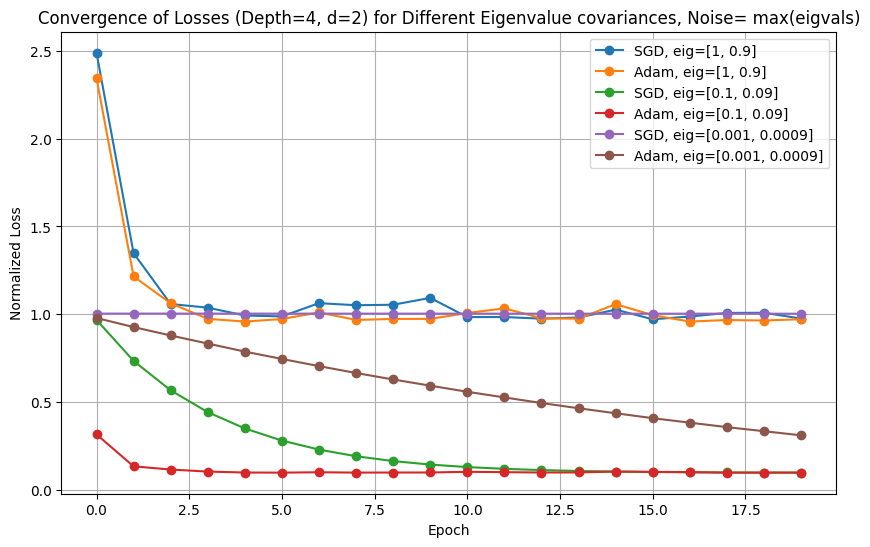

In [ ]:
depth = 4
width = 20
epochs = 20
batch_size = 100
lr_sgd = 0.1
lr_adam = 0.05
optimizers = ['SGD', 'Adam']
eigvals_list = [[1, .9], [0.1, 0.09], [0.001, 0.0009]]

results = {}
for eigvals in eigvals_list:
    print(f"\n--- Eigenvalues: {eigvals} ---")
    X, y, truew = make_2d_eigen_data(n=1000, eigvals=eigvals, noise=max(eigvals), seed=1)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

    w_norms_dict = {}
    losses = {}

    for opt_name in optimizers:
        print(f"Training {opt_name}...")
        lr = lr_sgd * max(eigvals) if opt_name=='SGD' else lr_adam * max(eigvals)
        norms, loss, _ = track_convergence(
            model_class=Net,
            X=X,
            Y=y,
            optim_name=opt_name,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            width=width,
            depth=depth,
            d=2,
            device='cpu',
            seed=1
        )
        w_norms_dict[opt_name] = [n[1] for n in norms]
        losses[opt_name] = [n / max(eigvals) for n in loss]

    results[tuple(eigvals)] = losses

plt.figure(figsize=(10,6))
for eigvals in eigvals_list:
    w_norms_dict = results[tuple(eigvals)]
    for opt_name in optimizers:
        plt.plot(w_norms_dict[opt_name], label=f"{opt_name}, eig={eigvals}", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.title(f"Convergence of Losses (Depth={depth}, d=2) for Different Eigenvalue covariances, Noise= max(eigvals)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch

# --- Parameters ---
depth = 2
width = 200
epochs = 20
batch_size = 100
lr_sgd = 0.01
lr_adam = 0.01
optimizers = ['SGD', 'Adam']
eigvals_list = [[1, 0.5], [0.1, 0.05], [0.001, 0.0005]]

# --- Loop over eigenvalue sets ---
results = {}

for eigvals in eigvals_list:
    print(f"\n--- Eigenvalues: {eigvals} ---")
    X, y, _ = make_2d_eigen_data(n=1000, eigvals=eigvals, noise=0.1, seed=1)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

    w_norms_dict = {}

    for opt_name in optimizers:
        print(f"Training {opt_name}...")
        lr = lr_sgd if opt_name=='SGD' else lr_adam
        norms, _ = track_convergence(
            model_class=Net,
            X=X,
            Y=y,
            optim_name=opt_name,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            width=width,
            depth=depth,
            d=2,
            device='cpu',
            seed=1
        )
        # Store only w norms
        w_norms_dict[opt_name] = [n[0] for n in norms]

    results[tuple(eigvals)] = w_norms_dict

# --- Plot results ---
plt.figure(figsize=(12,8))
for eigvals in eigvals_list:
    w_norms_dict = results[tuple(eigvals)]
    for opt_name in optimizers:
        plt.plot(w_norms_dict[opt_name], label=f"{opt_name}, eig={eigvals}", marker='o')
plt.xlabel("Epoch")
plt.ylabel("w Norm")
plt.title(f"Convergence of w Norms (Depth={depth}) for Different Eigenvalues")
plt.legend()
plt.grid(True)
plt.show()



--- Eigenvalues: [1, 0.5] ---
Training SGD...


NameError: name 'depht' is not defined

# Generate Data

In [ ]:
# --- very simple example --
np.random.seed(0)
X = np.random.randn(100, 1)
true_w = 2.0
y = X * true_w + np.random.randn(100, 1) * 0.3

In [ ]:
def make_2d_eigen_data(n=200, eigvals=[1.0, 0.1], noise=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)

    d = len(eigvals)
    # Random orthogonal matrix for eigenvectors
    Q, _ = np.linalg.qr(np.random.randn(d, d))
    Sigma = Q @ np.diag(eigvals) @ Q.T
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)

    # Ground-truth maapping (simple, fixed)
    true_w = np.array([[1.0], [1.0]])
    y = X @ true_w + noise * np.random.randn(n, 1)
    return X, y, true_w


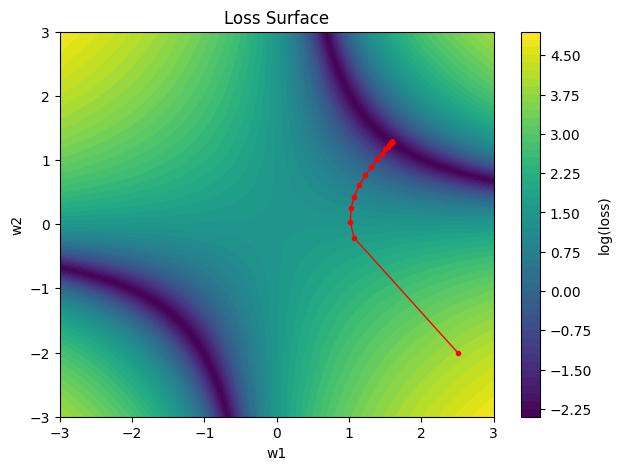

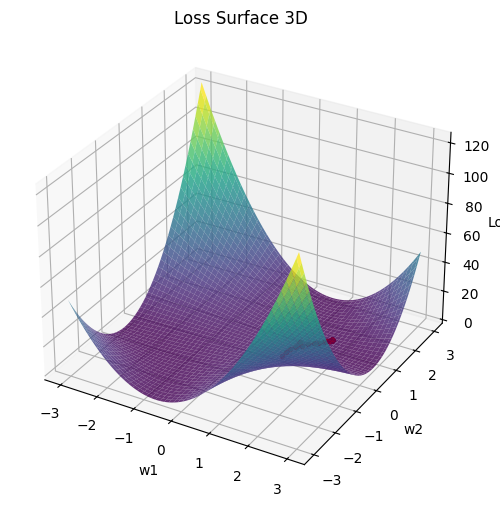

In [ ]:
# --- Generate toy data ---
np.random.seed(0)


# --- Create model and run optimizer ---
model = LinearNetwork(w1_init=2.5, w2_init=-2.0)
trajectory = gradient_descent(model, X, y, lr=0.05, n_steps=50)

# --- Plot loss surface and trajectory ---
plot_loss_surface(LinearNetwork, X, y, (-3, 3), (-3, 3), trajectory)
plot_loss_surface_3d(LinearNetwork, X, y, (-3, 3), (-3, 3), trajectory)


In [ ]:
X, y, w_true = make_2d_eigen_data(n=1000, eigvals=[5, 0.01], noise=0.1, seed=1)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
model = Net(width=20, depth=3, d=2)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([2000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


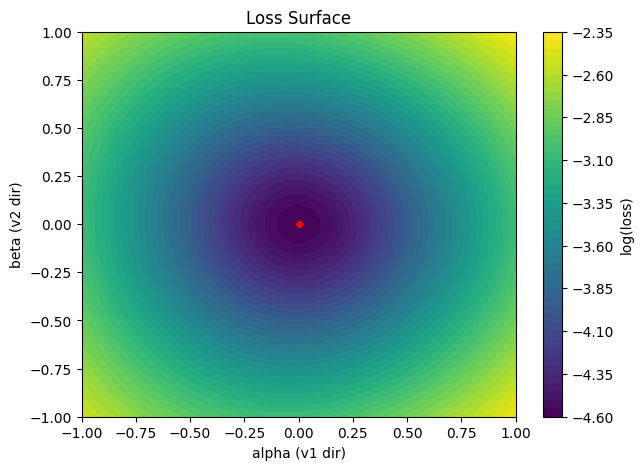

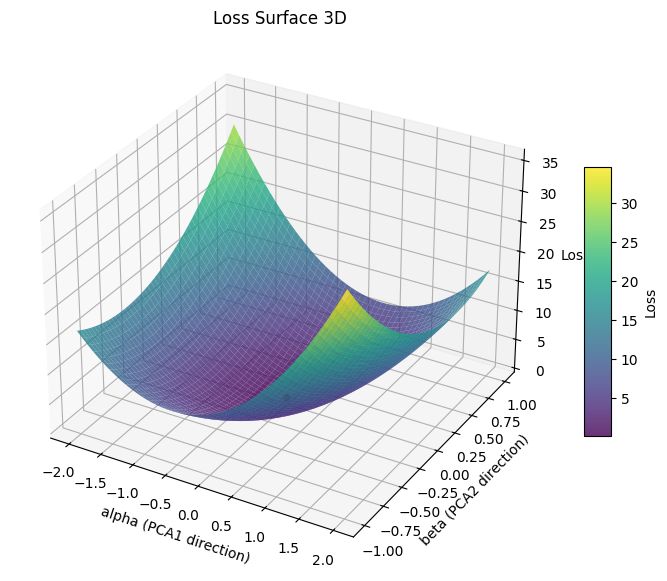

In [ ]:
trajectory = gradient_descent_sgd(model, X, y, lr=0.05, n_steps=50)
plot_loss_surface_net(model, X, y, (-1, 1), (-1, 1), trajectory)
plot_loss_surface_net_3d_pca(model, X, y, trajectory, alpha_range=(-2,2), beta_range=(-1,1))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([2000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


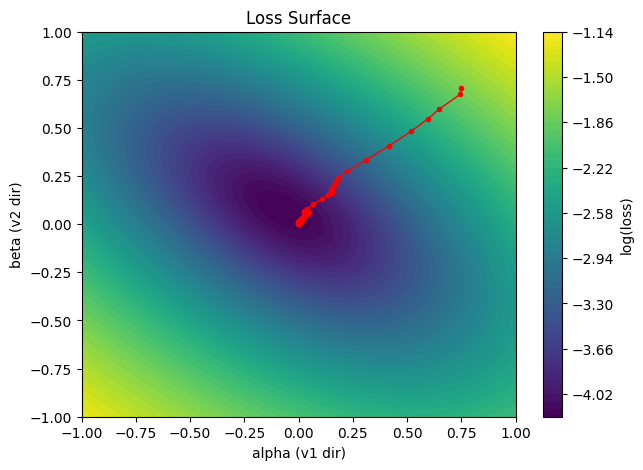

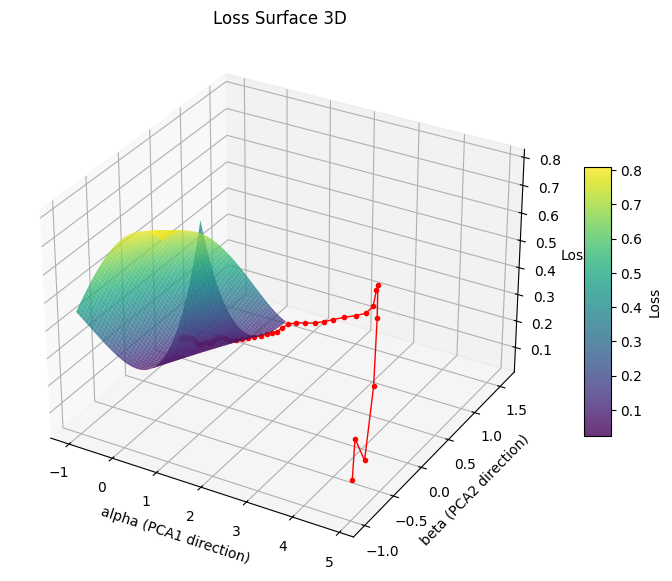

In [ ]:
trajectory_adam = gradient_descent_adam(model, X, y, lr=0.05, n_steps=50)
plot_loss_surface_net(model, X, y, (-1, 1), (-1, 1), trajectory_adam)
plot_loss_surface_net_3d_pca(model, X, y, trajectory_adam, alpha_range=(-1,1), beta_range=(-1,1))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


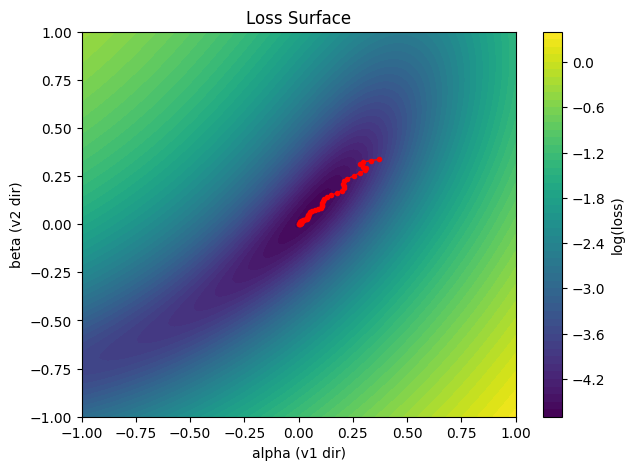

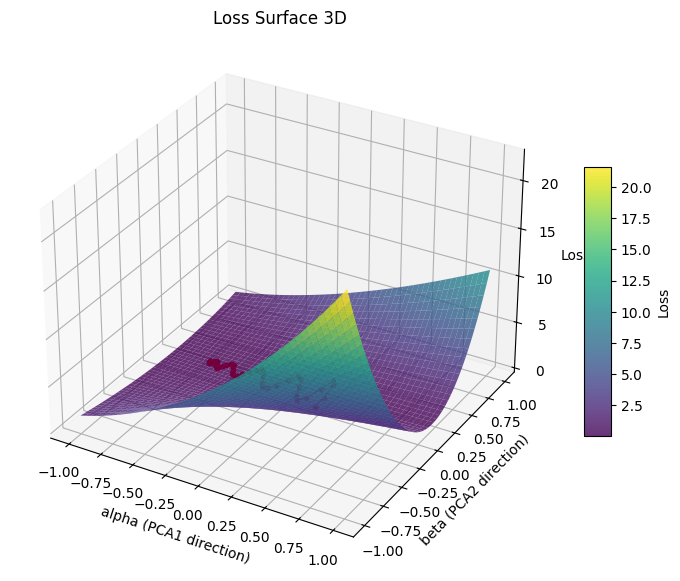

In [ ]:
trajectory_momentum = gradient_descent_momentum(model, X, y, lr=0.05, n_steps=50)
plot_loss_surface_net(model, X, y, (-1, 1), (-1, 1), trajectory_momentum)
plot_loss_surface_net_3d_pca(model, X, y, trajectory_momentum, alpha_range=(-1,1), beta_range=(-1,1))